# Image Processing and Computer Vision Project

In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import math
from sklearn.cluster import DBSCAN

## Step A - Multiple Product Detection
The first task is to develop an object detection system to identify single instance of products given: one reference image for each item and a scene image. This goal can be reached through the dectection of **local invariant features** and then matching the **keypoints**.

We first load the images and compute all the keypoints and the descriptors of the products and the scenes in advance

In [455]:
test_scenes = [1, 2, 3, 4, 5]
prod_images = [0, 1, 11, 19, 24, 25, 26]

dict_prod = {}
for prod in prod_images:
    # Load the product image both colour and grayscale
    img_prod = cv2.imread('models/'+str(prod)+'.jpg', cv2.IMREAD_COLOR)
    img_prod_gr = cv2.cvtColor(img_prod, cv2.COLOR_BGR2GRAY)
    
    # Detecting keypoints and computing the descriptors for each keypoints in the product image
    sift = cv2.xfeatures2d.SIFT_create()
    kp_p, des_p = sift.detectAndCompute(img_prod_gr, None)
    dict_prod[prod] = (img_prod, img_prod_gr, kp_p, des_p)


dict_scene = {}
for scene in test_scenes:
    # Load the scene image both colour and grayscale
    img_scene = cv2.imread('scenes/e'+str(scene)+'.png', cv2.IMREAD_COLOR)
    img_scene_gr = cv2.cvtColor(img_scene, cv2.COLOR_BGR2GRAY)
    
    # Equalize the histogram to improve the contrast
    img_scene_eq = cv2.equalizeHist(img_scene_gr)
    
    # Sharpen the image by convolving with the sharpen kernel
    sharpen_kernel = np.array([
                [0,-1,0],
                [-1,5,-1],
                [0,-1,0]])
    img_scene_pre = cv2.filter2D(img_scene_eq,-1,sharpen_kernel)
    img_scene_pre = np.abs(img_scene_pre)
    
    # Detecting keypoints and computing the descriptors for each keypoints in the scene image
    sift = cv2.xfeatures2d.SIFT_create()
    kp_s, des_s = sift.detectAndCompute(img_scene_pre, None)
    dict_scene[scene] = (img_scene, img_scene_gr, kp_s, des_s)


Then we run the matching algorithm

In [468]:
result_scene = {}
for scene in test_scenes:
    
    img_scene, img_scene_gr, kp_s, des_s = dict_scene[scene]
    
    result_prod = {}
    for prod in prod_images:
        img_prod, img_prod_gr, kp_p, des_p = dict_prod[prod]
        
        # Initializing the matching algorithm
        FLANN_INDEX_KDTREE = 1
        index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
        search_params = dict(checks = 50)
        flann = cv2.FlannBasedMatcher(index_params, search_params)

        # Matching the descriptors
        matches = flann.knnMatch(des_p,des_s,k=2)

        # Keeping only good matches as per Lowe's ratio test.
        good = []
        for m,n in matches:
            if m.distance < 0.7*n.distance:
                good.append(m)

        # If we have at least MIN_MATCH_COUNT matches we find the box of the object
        MIN_MATCH_COUNT = 80
        out_scene = False
        if len(good)>MIN_MATCH_COUNT:
            src_pts = np.float32([ kp_p[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
            dst_pts = np.float32([ kp_s[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

            # Calculating homography based on correspondences
            M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 3.0)

            # Matches mask for visualization of only matches used by RANSAC
            matchesMask = mask.ravel().tolist()

            # Apply homography to project corners of the query image into the image
            h,w = img_prod_gr.shape
            pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
            dst = cv2.perspectiveTransform(pts,M)

            # Calculate the bounding box
            x, y, w, h = cv2.boundingRect(dst)
            
            # Check rectangularity
            bounds_area = cv2.contourArea(dst)
            rect_area = w * h
            rectangularity = bounds_area / rect_area
            
2

        else:
            print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
            matchesMask = None
        
        result_scene[scene] = result_prod

Not enough matches are found - 8/80
Not enough matches are found - 17/80
Not enough matches are found - 63/80
Not enough matches are found - 64/80
Not enough matches are found - 15/80
Not enough matches are found - 11/80
Not enough matches are found - 68/80
Not enough matches are found - 7/80
Not enough matches are found - 19/80
Not enough matches are found - 62/80
Not enough matches are found - 7/80
Not enough matches are found - 11/80
Not enough matches are found - 72/80
Not enough matches are found - 76/80
Not enough matches are found - 8/80
Not enough matches are found - 21/80
Not enough matches are found - 7/80


To filter out incorret matches due to similar products (for example the Nesquik boxes) I check if the barycenter of a box is contained in another box and then remove the one with smaller area

In [469]:
for s in result_scene:
    poss_overlap = []
    for p1 in result_scene[s]:
        n = len(result_scene[s][p1])
        for i in range(n):
            #print('s: '+str(s)+', p1: '+str(p1)+', i: '+str(i)+', n: '+str(n))
            x, y, w, h = cv2.boundingRect(result_scene[s][p1][i])
            center = ((x + w // 2), (y + h // 2))
            p1_area = cv2.contourArea(result_scene[s][p1][i])
            for p2 in result_scene[s]:
                if p1 < p2:
                    n2 = len(result_scene[s][p2])
                    for i2 in range(n2):
                        x2, y2, w2, h2 = cv2.boundingRect(result_scene[s][p2][i2])
                        p2_area = cv2.contourArea(result_scene[s][p2][i2])
                        if (x2<=center[0]<=x2+w2) and (y2<=center[1]<=y2+h2):
                            if p1_area <= p2_area:
                                result_scene[s][p1][i] = []
                            else:
                                result_scene[s][p2][i2] = []
                            
for s in result_scene:
    for p in result_scene[s]:
        result_scene[s][p] = [x for x in result_scene[s][p] if len(x)!=0]        
    result_scene[s] = {k: v for k, v in result_scene[s].items() if v}

In [33]:
kp_p[0].pt

(2.6569206714630127, 390.98797607421875)

In [32]:
kp_p[0].size, kp_s[0].size, kp_p[0].angle, kp_s[0].angle 

(2.1213436126708984, 1.9021503925323486, 100.589111328125, 293.35430908203125)

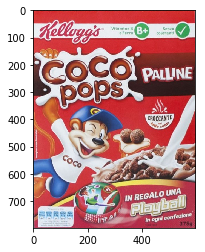

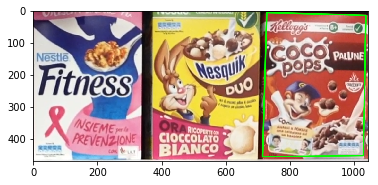

In [27]:
# Drawing bounding box
s = 2
p = 25
plt.imshow(cv2.cvtColor(dict_prod[p][0],cv2.COLOR_BGR2RGB))
plt.show()
final_img = dict_scene[s][0].copy()
final_img = cv2.polylines(final_img,np.int32([result_scene[s][p][0]]),True,(0,255,0), 3, cv2.LINE_AA)
final_img_rgb = cv2.cvtColor(final_img,cv2.COLOR_BGR2RGB)
plt.imshow(final_img_rgb)
plt.show()

The following cell shows for each matched product the relative position in each scene 

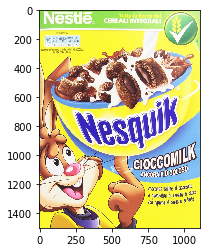

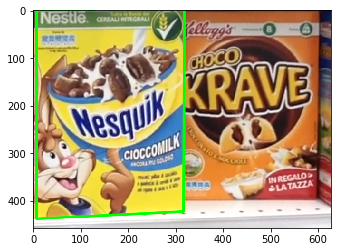

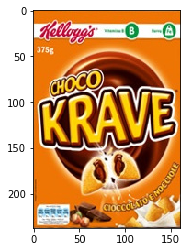

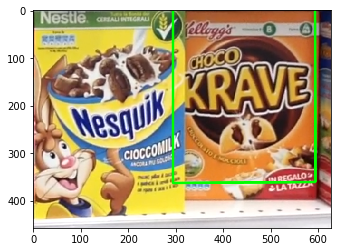

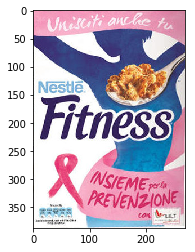

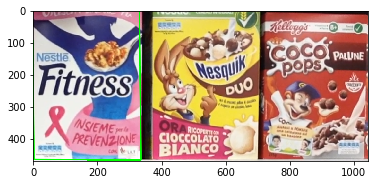

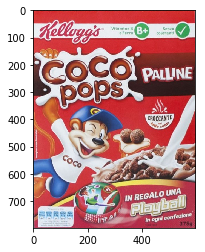

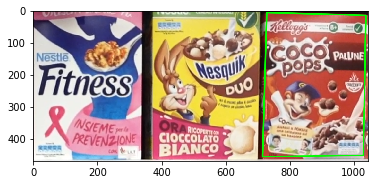

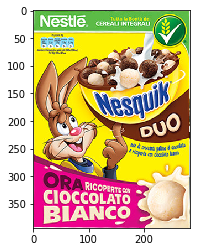

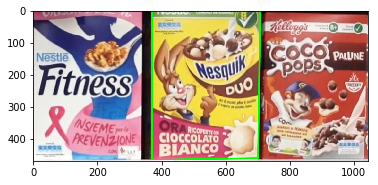

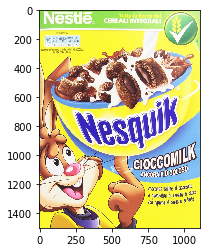

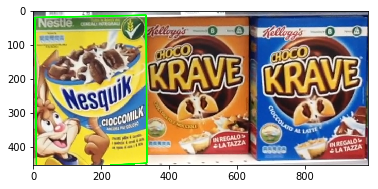

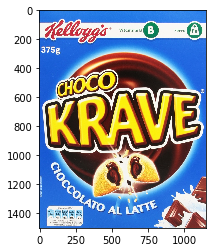

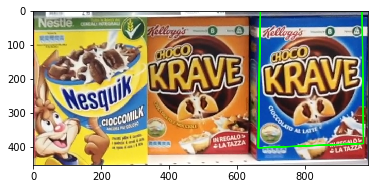

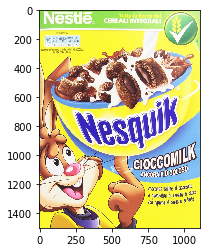

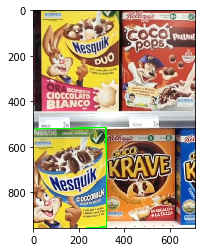

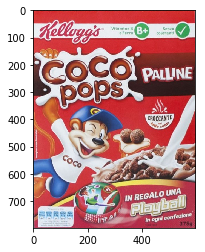

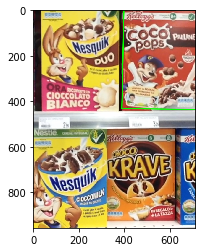

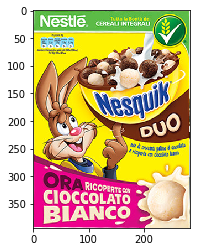

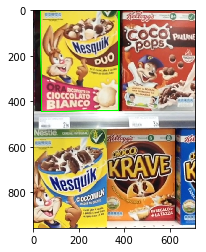

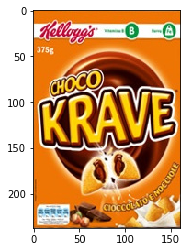

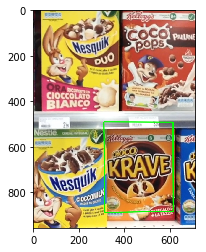

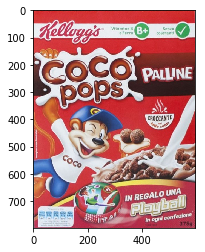

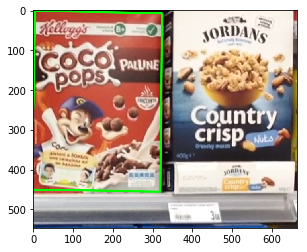

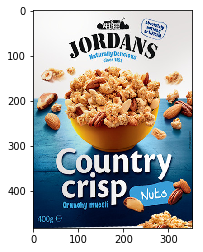

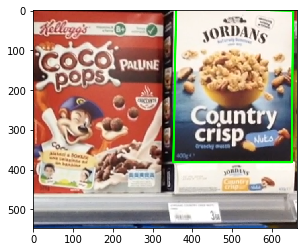

In [470]:
# Drawing bounding box
for s in result_scene.keys():
    for p in result_scene[s].keys():
        plt.imshow(cv2.cvtColor(dict_prod[p][0],cv2.COLOR_BGR2RGB))
        plt.show()
        final_img = dict_scene[s][0].copy()
        final_img = cv2.polylines(final_img,np.int32([result_scene[s][p][0]]),True,(0,255,0), 3, cv2.LINE_AA)
        final_img_rgb = cv2.cvtColor(final_img,cv2.COLOR_BGR2RGB)
        plt.imshow(final_img_rgb)
        plt.show()

The following cell outputs the result as requested in the project description

In [6]:
# Print results
for s in result_scene.keys():
    print('Scene '+str(s))
    
    for p in result_scene[s].keys():
        n = len(result_scene[s][p])
        print('\tProduct '+str(p)+' - '+str(n)+' instance found:')
        
        for i in range(n):
            x, y, w, h = cv2.boundingRect(result_scene[s][p][i])
            center = ((x + w // 2), (y + h // 2))
            print('\t\tInstance '+str(i+1)+' {position: '+str(center)+', width: '+str(w)+'px, height: '+str(h)+'px}')
        

Scene 1
	Product 0 - 1 instance found:
		Instance 1 {position: (163, 217), width: 312px, height: 445px}
	Product 11 - 1 instance found:
		Instance 1 {position: (445, 165), width: 304px, height: 391px}
Scene 2
	Product 24 - 1 instance found:
		Instance 1 {position: (167, 218), width: 340px, height: 496px}
	Product 25 - 1 instance found:
		Instance 1 {position: (877, 230), width: 323px, height: 446px}
	Product 26 - 1 instance found:
		Instance 1 {position: (540, 218), width: 338px, height: 491px}
Scene 3
	Product 1 - 1 instance found:
		Instance 1 {position: (818, 198), width: 312px, height: 412px}
	Product 26 - 1 instance found:
		Instance 1 {position: (122, 305), width: 453px, height: 648px}
Scene 4
	Product 0 - 1 instance found:
		Instance 1 {position: (158, 741), width: 329px, height: 453px}
	Product 25 - 1 instance found:
		Instance 1 {position: (554, 207), width: 331px, height: 453px}
	Product 26 - 1 instance found:
		Instance 1 {position: (204, 196), width: 345px, height: 498px}
	

## Step B - Multiple Instance Detection

In [369]:
test_scenes = [1, 2, 3, 4, 5]
prod_images = [0, 1, 11, 19, 24, 25, 26]

dict_prod = {}
for prod in prod_images:
    # Load the product image both colour and grayscale
    img_prod = cv2.imread('models/'+str(prod)+'.jpg', cv2.IMREAD_COLOR)
    img_prod_gr = cv2.cvtColor(img_prod, cv2.COLOR_BGR2GRAY)
    
    # Detecting keypoints and computing the descriptors for each keypoints in the product image
    sift = cv2.xfeatures2d.SIFT_create()
    kp_p, des_p = sift.detectAndCompute(img_prod_gr, None)
    
    # Compute the barycenter for the GHT
    x = np.mean([kp.pt[0] for kp in kp_p])
    y = np.mean([kp.pt[1] for kp in kp_p])
    barycen_p = [x,y]
    
    dict_prod[prod] = (img_prod, img_prod_gr, kp_p, des_p, barycen_p)


dict_scene = {}
for scene in test_scenes:
    # Load the scene image both colour and grayscale
    img_scene = cv2.imread('scenes/m'+str(scene)+'.png', cv2.IMREAD_COLOR)
    img_scene_gr = cv2.cvtColor(img_scene, cv2.COLOR_BGR2GRAY)
    
    # Equalize the histogram to improve the contrast
    img_scene_eq = cv2.equalizeHist(img_scene_gr)
    
    # Sharpen the image by convolving with the sharpen kernel
    sharpen_kernel = np.array([
                [0,-1,0],
                [-1,5,-1],
                [0,-1,0]])
    img_scene_pre = cv2.filter2D(img_scene_eq,-1,sharpen_kernel)
    img_scene_pre = np.abs(img_scene_pre)
    
    # Detecting keypoints and computing the descriptors for each keypoints in the scene image
    sift = cv2.xfeatures2d.SIFT_create()
    kp_s, des_s = sift.detectAndCompute(img_scene_pre, None)
    dict_scene[scene] = (img_scene, img_scene_gr, kp_s, des_s)


In [451]:
result_scene = {}
for scene in test_scenes:
    
    img_scene, img_scene_gr, kp_s, des_s = dict_scene[scene]
    
    result_prod = {}
    for prod in prod_images:
        img_prod, img_prod_gr, kp_p, des_p, barycen_p = dict_prod[prod]
        
        # Initializing the matching algorithm
        FLANN_INDEX_KDTREE = 1
        index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
        search_params = dict(checks = 50)
        flann = cv2.FlannBasedMatcher(index_params, search_params)

        # Matching the descriptors
        matches = flann.knnMatch(des_p,des_s,k=2)

        # Keeping only good matches as per Lowe's ratio test.
        good = []
        for m,n in matches:
            if m.distance < 0.7*n.distance:
                good.append(m)

        # Online phase of the GHT algorithm
        aa_quant_fact = 5
        aa_matrix = np.zeros((img_scene_gr.shape[0]//aa_quant_fact, img_scene_gr.shape[1]//aa_quant_fact))
        dict_matches = {}

        for m in good:
            # Retrieve only good matches
            kp_p_good = kp_p[m.queryIdx]
            kp_s_good = kp_s[m.trainIdx]

            # Compute the vector that connects each keypoint to the barycenter
            vec = np.subtract(barycen_p, kp_p_good.pt)

            # Scale the vector 
            vec_scaled = np.multiply(vec, kp_s_good.size/kp_p_good.size)

            # Rotate the vector
            rot_angle = math.radians(kp_s_good.angle - kp_p_good.angle)
            rot_matrix = np.array(((np.cos(rot_angle), -np.sin(rot_angle)),(np.sin(rot_angle), np.cos(rot_angle))))
            vec_scaled_rot = rot_matrix.dot(vec_scaled)

            # Calculate barycenter
            bar_x = int(round(kp_s_good.pt[0] + vec_scaled_rot[0])//aa_quant_fact)
            bar_y = int(round(kp_s_good.pt[1] + vec_scaled_rot[1])//aa_quant_fact)

            bar = (bar_x, bar_y)
            if bar in dict_matches.keys():
                dict_matches[bar].append(m)
            else:
                dict_matches[bar] = [m]

            # Cast a vote
            if 0 <= bar[0] < aa_matrix.shape[1] and 0 <= bar[1] < aa_matrix.shape[0]:
                aa_matrix[bar[1], bar[0]] += 1
            
        # Find clusters
        # Take non zero values from the aa_matrix
        non_null=np.concatenate((np.nonzero(aa_matrix)[1].reshape((-1,1)), np.nonzero(aa_matrix)[0].reshape((-1,1))), axis=1)
        
        # In order to take into account votes
        non_null_ext = []
        for i in range(non_null.shape[0]):
            for j in range(int(aa_matrix[non_null[i,1],non_null[i,0]])):
                non_null_ext.append(non_null[i].tolist())
        non_null_ext = np.array(non_null_ext)
        
        # Apply DBSCAN to find the clusters
        y = DBSCAN(eps=15, min_samples=20).fit_predict(non_null_ext)
        cluster_labels_all = np.unique(y)
        cluster_labels = cluster_labels_all[cluster_labels_all != -1]
        n_clusters = len(cluster_labels)
        cl = []
        for i in cluster_labels:
            cl.append(non_null_ext[y==i].tolist())

        for instance in cl:
            instance_matches = []
            for pt in instance:
                instance_matches += dict_matches[tuple(pt)]
            
            
            # If we have at least MIN_MATCH_COUNT matches we find the box of the object
            MIN_POINT_COUNT = 30
            out_scene = False
            if len(instance_matches) > MIN_POINT_COUNT:
                src_pts = np.float32([ kp_p[m.queryIdx].pt for m in instance_matches ]).reshape(-1,1,2)
                dst_pts = np.float32([ kp_s[m.trainIdx].pt for m in instance_matches ]).reshape(-1,1,2)

                # Calculating homography based on correspondences
                M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 3.0)

                # Matches mask for visualization of only matches used by RANSAC
                matchesMask = mask.ravel().tolist()

                # Apply homography to project corners of the query image into the image
                h,w = img_prod_gr.shape
                pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
                dst = cv2.perspectiveTransform(pts,M)

                # Calculate the bounding box
                x, y, w, h = cv2.boundingRect(dst)
                
                
                # Check rectangularity
                bounds_area = cv2.contourArea(dst)
                rect_area = w * h
                rectangularity = bounds_area / rect_area

                # Check if it's inside the scene
                for pt in dst:
                    if pt[0][0] < -90 or pt[0][1] < -90:
                        out_scene = True

                if rectangularity > 0.8 and not out_scene:
                    if prod in result_prod.keys():
                        result_prod[prod].append(dst)
                    else:
                        result_prod[prod] = [dst]

            else:
                print( "Not enough matches are found - {}/{}".format(len(instance_matches), MIN_POINT_COUNT) )
                matchesMask = None

        result_scene[scene] = result_prod

Not enough matches are found - 21/30
Not enough matches are found - 24/30


In [452]:
#result_scene_copy = {}
for s in result_scene:
    poss_overlap = []
    for p1 in result_scene[s]:
        n = len(result_scene[s][p1])
        for i in range(n):
            #print('s: '+str(s)+', p1: '+str(p1)+', i: '+str(i)+', n: '+str(n))
            x, y, w, h = cv2.boundingRect(result_scene[s][p1][i])
            center = ((x + w // 2), (y + h // 2))
            p1_area = cv2.contourArea(result_scene[s][p1][i])
            for p2 in result_scene[s]:
                if p1 < p2:
                    n2 = len(result_scene[s][p2])
                    for i2 in range(n2):
                        x2, y2, w2, h2 = cv2.boundingRect(result_scene[s][p2][i2])
                        p2_area = cv2.contourArea(result_scene[s][p2][i2])
                        if (x2<=center[0]<=x2+w2) and (y2<=center[1]<=y2+h2):
                            if p1_area <= p2_area:
                                result_scene[s][p1][i] = []
                            else:
                                result_scene[s][p2][i2] = []
                            
for s in result_scene:
    for p in result_scene[s]:
        result_scene[s][p] = [x for x in result_scene[s][p] if len(x)!=0]        
    result_scene[s] = {k: v for k, v in result_scene[s].items() if v}

In [248]:
result_scene = copy.deepcopy(result_scene_copy)

In [453]:
for s in result_scene:
    for p in result_scene[s]:
        result_scene[s][p] = [x for x in result_scene[s][p] if len(x)!=0]        
    result_scene[s] = {k: v for k, v in result_scene[s].items() if v}

In [112]:
poss_overlap

[]

In [145]:
h,w

(644, 481)

In [404]:
result_scene

{1: {0: [array([[[ 824.3665   ,  -11.640864 ]],
   
          [[ 835.88916  ,  339.1105   ]],
   
          [[1072.2231   ,  336.51718  ]],
   
          [[1084.5889   ,   -6.4977994]]], dtype=float32)],
  24: [array([[[  3.3182476, -40.992374 ]],
   
          [[ 15.30701  , 462.3078   ]],
   
          [[366.84323  , 465.7193   ]],
   
          [[353.13403  , -29.828316 ]]], dtype=float32),
   array([[[377.50143 , -31.657812]],
   
          [[384.76093 , 462.88553 ]],
   
          [[719.85315 , 465.3581  ]],
   
          [[715.4656  , -22.068535]]], dtype=float32)],
  25: [array([[[1111.185   ,    7.117229]],
   
          [[1097.416   ,  455.05972 ]],
   
          [[1411.7234  ,  447.75168 ]],
   
          [[1420.4987  ,   16.211739]]], dtype=float32)],
  26: [array([[[ 754.87756 ,  -26.304796]],
   
          [[ 754.53296 ,  464.11404 ]],
   
          [[1084.757   ,  459.44806 ]],
   
          [[1091.9174  ,  -23.391129]]], dtype=float32)]},
 2: {0: [array([[[  4.0395646,  

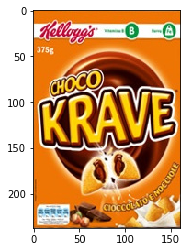

KeyError: 11

In [92]:
# Drawing bounding box
s = 2
p = 11
plt.imshow(cv2.cvtColor(dict_prod[p][0],cv2.COLOR_BGR2RGB))
plt.show()
final_img = dict_scene[s][0].copy()
final_img = cv2.polylines(final_img,np.int32([result_scene[s][p][1]]),True,(0,255,0), 3, cv2.LINE_AA)
final_img_rgb = cv2.cvtColor(final_img,cv2.COLOR_BGR2RGB)
plt.imshow(final_img_rgb)
plt.show()

In [142]:
x, y, w, h = cv2.boundingRect(result_scene[2][26][0])
bounds_area = cv2.contourArea(result_scene[2][26][0])
rect_area = w * h
rectangularity = bounds_area / rect_area

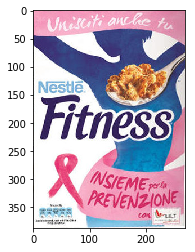

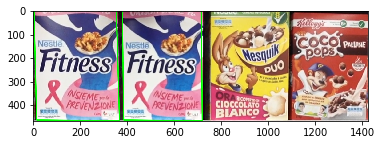

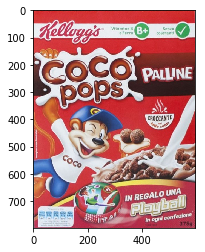

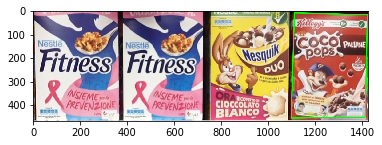

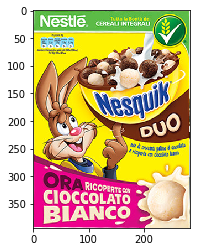

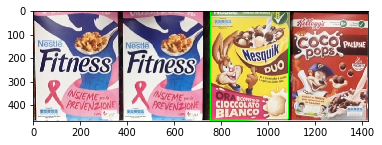

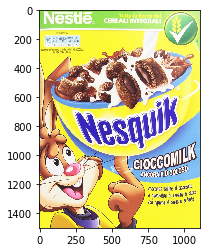

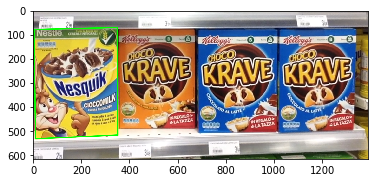

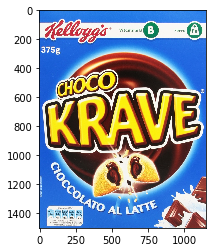

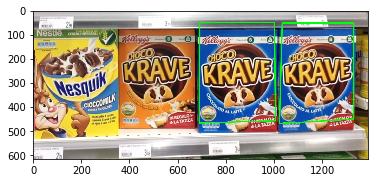

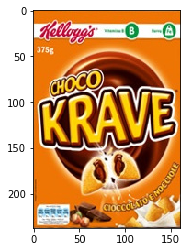

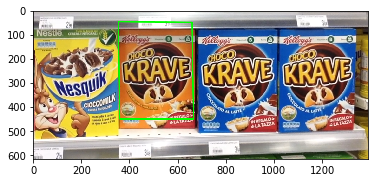

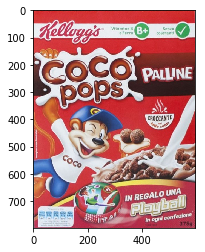

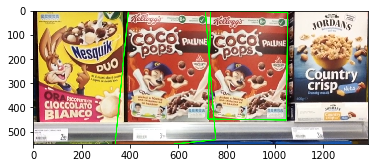

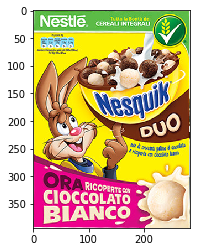

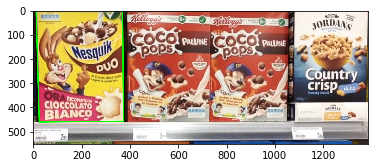

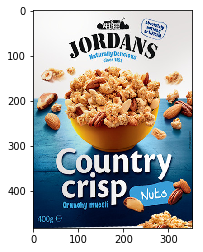

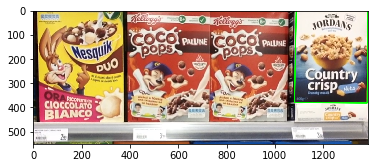

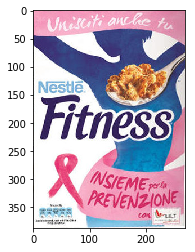

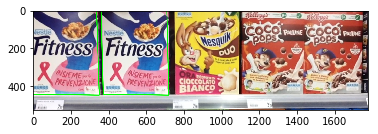

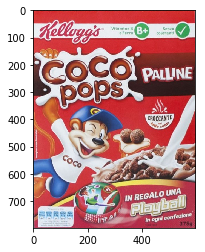

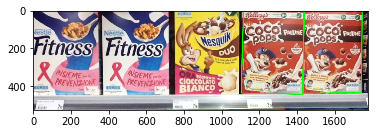

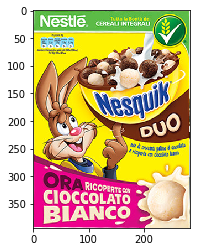

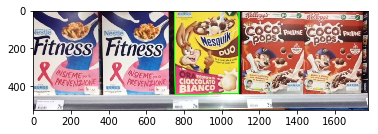

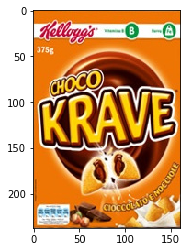

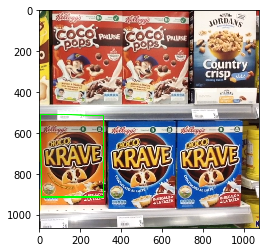

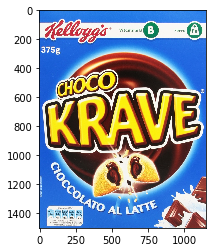

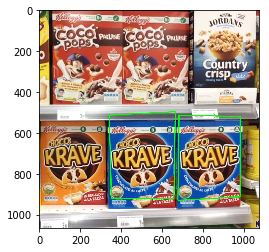

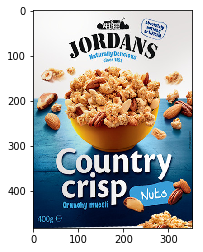

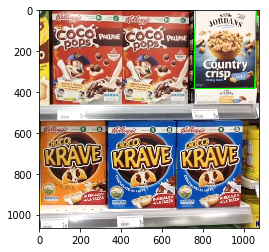

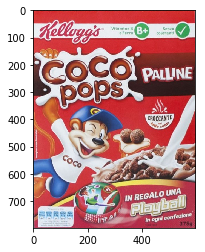

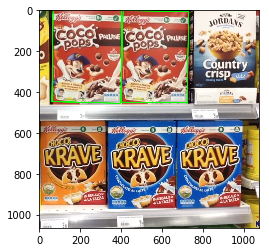

In [454]:
for s in result_scene.keys():
    for p in result_scene[s].keys():
        n = len(result_scene[s][p])
        plt.imshow(cv2.cvtColor(dict_prod[p][0],cv2.COLOR_BGR2RGB))
        plt.show()
        final_img = dict_scene[s][0].copy()
        for i in range(n):
            final_img = cv2.polylines(final_img,np.int32([result_scene[s][p][i]]),True,(0,255,0), 3, cv2.LINE_AA)
        final_img_rgb = cv2.cvtColor(final_img,cv2.COLOR_BGR2RGB)
        plt.imshow(final_img_rgb)
        plt.show()

In [374]:
# Print results
for s in result_scene.keys():
    print('Scene '+str(s))
    
    for p in result_scene[s].keys():
        n = len(result_scene[s][p])
        print('\tProduct '+str(p)+' - '+str(n)+' instance found:')
        
        for i in range(n):
            x, y, w, h = cv2.boundingRect(result_scene[s][p][i])
            center = ((x + w // 2), (y + h // 2))
            print('\t\tInstance '+str(i+1)+' {position: '+str(center)+', width: '+str(w)+'px, height: '+str(h)+'px}')
        

Scene 1
	Product 24 - 2 instance found:
		Instance 1 {position: (185, 212), width: 365px, height: 507px}
		Instance 2 {position: (549, 218), width: 341px, height: 496px}
	Product 25 - 1 instance found:
		Instance 1 {position: (1258, 232), width: 325px, height: 450px}
	Product 26 - 1 instance found:
		Instance 1 {position: (923, 219), width: 338px, height: 492px}
Scene 2
	Product 0 - 1 instance found:
		Instance 1 {position: (178, 302), width: 350px, height: 461px}
	Product 1 - 3 instance found:
		Instance 1 {position: (850, 257), width: 318px, height: 419px}
		Instance 2 {position: (513, 249), width: 307px, height: 402px}
		Instance 3 {position: (1182, 268), width: 310px, height: 370px}
Scene 3
Scene 4
Scene 5


In [141]:
cv2.contourArea(result_scene[1][24][0])

175197.51915524638

## Step C - Whole shelve challenge

In [59]:
test_scenes = [1, 2, 3, 4, 5]
prod_images = [i for i in range(24)]

dict_prod = {}
for prod in prod_images:
    # Load the product image both colour and grayscale
    img_prod = cv2.imread('models/'+str(prod)+'.jpg', cv2.IMREAD_COLOR)
    img_prod_gr = cv2.cvtColor(img_prod, cv2.COLOR_BGR2GRAY)
    
    # Detecting keypoints and computing the descriptors for each keypoints in the product image
    sift = cv2.xfeatures2d.SIFT_create()
    kp_p, des_p = sift.detectAndCompute(img_prod_gr, None)
    
    # Compute the barycenter for the GHT
    x = np.mean([kp.pt[0] for kp in kp_p])
    y = np.mean([kp.pt[1] for kp in kp_p])
    barycen_p = [x,y]
    
    dict_prod[prod] = (img_prod, img_prod_gr, kp_p, des_p, barycen_p)


dict_scene = {}
for scene in test_scenes:
    # Load the scene image both colour and grayscale
    img_scene = cv2.imread('scenes/h'+str(scene)+'.jpg', cv2.IMREAD_COLOR)
    img_scene_gr = cv2.cvtColor(img_scene, cv2.COLOR_BGR2GRAY)
    
    # Equalize the histogram to improve the contrast
    img_scene_eq = cv2.equalizeHist(img_scene_gr)
    
    # Sharpen the image by convolving with the sharpen kernel
    sharpen_kernel = np.array([
                [0,-1,0],
                [-1,5,-1],
                [0,-1,0]])
    img_scene_pre = cv2.filter2D(img_scene_eq,-1,sharpen_kernel)
    img_scene_pre = np.abs(img_scene_pre)
    
    # Detecting keypoints and computing the descriptors for each keypoints in the scene image
    sift = cv2.xfeatures2d.SIFT_create()
    kp_s, des_s = sift.detectAndCompute(img_scene_pre, None)
    dict_scene[scene] = (img_scene, img_scene_gr, kp_s, des_s)


In [60]:
result_scene = {}
for scene in test_scenes:
    
    img_scene, img_scene_gr, kp_s, des_s = dict_scene[scene]
    
    result_prod = {}
    for prod in prod_images:
        img_prod, img_prod_gr, kp_p, des_p, barycen_p = dict_prod[prod]
        
        # Initializing the matching algorithm
        FLANN_INDEX_KDTREE = 1
        index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
        search_params = dict(checks = 50)
        flann = cv2.FlannBasedMatcher(index_params, search_params)

        # Matching the descriptors
        matches = flann.knnMatch(des_p,des_s,k=2)

        # Keeping only good matches as per Lowe's ratio test.
        good = []
        for m,n in matches:
            if m.distance < 0.7*n.distance:
                good.append(m)

        # Online phase of the GHT algorithm
        aa_quant_fact = 5
        aa_matrix = np.zeros((img_scene_gr.shape[0]//aa_quant_fact, img_scene_gr.shape[1]//aa_quant_fact))
        dict_matches = {}

        for m in good:
            # Retrieve only good matches
            kp_p_good = kp_p[m.queryIdx]
            kp_s_good = kp_s[m.trainIdx]

            # Compute the vector that connects each keypoint to the barycenter
            vec = np.subtract(barycen_p, kp_p_good.pt)

            # Scale the vector 
            vec_scaled = np.multiply(vec, kp_s_good.size/kp_p_good.size)

            # Rotate the vector
            rot_angle = math.radians(kp_s_good.angle - kp_p_good.angle)
            rot_matrix = np.array(((np.cos(rot_angle), -np.sin(rot_angle)),(np.sin(rot_angle), np.cos(rot_angle))))
            vec_scaled_rot = rot_matrix.dot(vec_scaled)

            # Calculate barycenter
            bar_x = int(round(kp_s_good.pt[0] + vec_scaled_rot[0])//aa_quant_fact)
            bar_y = int(round(kp_s_good.pt[1] + vec_scaled_rot[1])//aa_quant_fact)

            bar = (bar_x, bar_y)
            if bar in dict_matches.keys():
                dict_matches[bar].append(m)
            else:
                dict_matches[bar] = [m]

            # Cast a vote
            if 0 <= bar[0] < aa_matrix.shape[1] and 0 <= bar[1] < aa_matrix.shape[0]:
                aa_matrix[bar[1], bar[0]] += 1
            
        # Find clusters
        # Take non zero values from the aa_matrix
        non_null=np.concatenate((np.nonzero(aa_matrix)[1].reshape((-1,1)), np.nonzero(aa_matrix)[0].reshape((-1,1))), axis=1)
        
        # In order to take into account votes
        non_null_ext = []
        for i in range(non_null.shape[0]):
            for j in range(int(aa_matrix[non_null[i,1],non_null[i,0]])):
                non_null_ext.append(non_null[i].tolist())
        non_null_ext = np.array(non_null_ext)
        
        # Apply DBSCAN to find the clusters
        y = DBSCAN(eps=10, min_samples=15).fit_predict(non_null_ext)
        cluster_labels_all = np.unique(y)
        cluster_labels = cluster_labels_all[cluster_labels_all != -1]
        n_clusters = len(cluster_labels)
        cl = []
        for i in cluster_labels:
            cl.append(non_null_ext[y==i].tolist())

        for instance in cl:
            instance_matches = []
            for pt in instance:
                instance_matches += dict_matches[tuple(pt)]
            
            
            # If we have at least MIN_MATCH_COUNT matches we find the box of the object
            MIN_POINT_COUNT = 30
            if len(instance_matches) > MIN_POINT_COUNT:
                src_pts = np.float32([ kp_p[m.queryIdx].pt for m in instance_matches ]).reshape(-1,1,2)
                dst_pts = np.float32([ kp_s[m.trainIdx].pt for m in instance_matches ]).reshape(-1,1,2)

                # Calculating homography based on correspondences
                M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 3.0)

                # Matches mask for visualization of only matches used by RANSAC
                matchesMask = mask.ravel().tolist()

                # Apply homography to project corners of the query image into the image
                h,w = img_prod_gr.shape
                pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
                dst = cv2.perspectiveTransform(pts,M)

                # Calculate the bounding box
                x, y, w, h = cv2.boundingRect(dst)
                
                if prod in result_prod.keys():
                    result_prod[prod].append(dst)
                else:
                    result_prod[prod] = [dst]

            else:
                print( "Not enough matches are found - {}/{}".format(len(instance_matches), MIN_POINT_COUNT) )
                matchesMask = None

        result_scene[scene] = result_prod

ValueError: Expected 2D array, got 1D array instead:
array=[].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.